In [1]:
import torch
import cmws.util
import cmws.examples.timeseries.util as timeseries_util
import cmws.examples.timeseries.data as data
from cmws.examples.timeseries import run
import matplotlib.pyplot as plt
import cmws.examples.timeseries.inference
from cmws.examples.timeseries import lstm_util
import textwrap
from cmws import losses


def get_num_base_kernels(raw_expression, eos):
    """
    Args:
        raw_expression [*shape, max_num_chars]
        eos [*shape, max_num_chars]

    Returns: [*shape]
    """
    # Extract
    device = raw_expression.device
    max_num_chars = raw_expression.shape[-1]
    shape = raw_expression.shape[:-1]
    num_elements = cmws.util.get_num_elements(shape)

    # Flatten
    raw_expression_flattened = raw_expression.view(-1, max_num_chars)
    eos_flattened = eos.view(-1, max_num_chars)

    # Compute num timesteps
    # [num_elements]
    num_timesteps_flattened = lstm_util.get_num_timesteps(eos_flattened)

    result = []
    for element_id in range(num_elements):
        result.append(
            timeseries_util.count_base_kernels(
                raw_expression_flattened[element_id, : num_timesteps_flattened[element_id]]
            )
        )
    return torch.tensor(result, device=device).long().view(shape)


def get_full_expression(raw_expression, eos, raw_gp_params):
    num_chars = lstm_util.get_num_timesteps(eos)
    num_base_kernels = get_num_base_kernels(
        raw_expression, eos
    )
    long_expression = timeseries_util.get_long_expression(
        timeseries_util.get_expression(
            raw_expression[: num_chars]
        )
    )
    try:
        kernel = timeseries_util.Kernel(
            timeseries_util.get_expression(raw_expression[: num_chars]),
            raw_gp_params[ : num_base_kernels],
        )
        return timeseries_util.get_long_expression_with_params(timeseries_util.get_expression(raw_expression[: num_chars]), kernel.params)
    except timeseries_util.ParsingError as e:
        print(e)
        return long_expression


def plot_obs(ax, obs):
    """
    Args
        ax
        obs [num_timesteps]
    """
    if torch.is_tensor(obs):
        obs = obs.cpu().numpy()
    ax.plot(obs, color="C0")
    ax.set_ylim(-4, 4)
    ax.set_xticks([])
    ax.set_yticks([-4, 4])
    ax.tick_params(axis="y", direction="in")

    
    
def plot_predictions_timeseries(generative_model, guide, obs, memory=None, obs_id=None):
    """
    Args:
        generative_model
        guide
        obs: [num_test_obs, num_timesteps]
        memory
        obs_id
    """
    num_samples = 1
    num_test_obs, num_timesteps = obs.shape
    assert num_test_obs == 1

    # Sample latent
    num_svi_iterations = 1
    if memory is None:
        num_particles = 5
        latent, log_weight = cmws.examples.timeseries.inference.svi_importance_sampling(
            num_particles, num_svi_iterations, obs, generative_model, guide
        )
    else:
        assert obs_id is not None
        num_particles = memory.size
        # latent, log_weight = cmws.examples.timeseries.inference.svi_memory(
        #     num_svi_iterations, obs, obs_id, generative_model, guide, memory
        # )
        latent, log_weight = cmws.examples.timeseries.inference.importance_sample_memory(
            num_particles, num_svi_iterations, obs, obs_id, generative_model, guide, memory
        )
    x, eos, raw_gp_params = latent
    num_chars = lstm_util.get_num_timesteps(eos)

    # Sort by log weight
    # [num_test_obs, num_particles], [num_test_obs, num_particles]
    _, sorted_indices = torch.sort(log_weight.T, descending=True)

    # Sample predictions
    # -- Expand obs
    obs_expanded = obs[None].expand(num_particles, num_test_obs, num_timesteps)

    # -- Sample predictions
    obs_predictions = generative_model.sample_obs_predictions(latent, obs_expanded, [num_samples])

    # Plot
    num_rows = num_test_obs
    num_cols = num_particles
    fig, axss = plt.subplots(
        num_rows,
        num_cols,
        figsize=(3 * num_cols, 2 * num_rows),
        sharex=True,
        sharey=True,
        squeeze=False,
    )

    for test_obs_id in range(num_test_obs):
        for particle_id in range(num_particles):
            # Plot obs
            ax = axss[test_obs_id, particle_id]
            plot_obs(ax, obs[test_obs_id])

            # Compute sorted particle id
            sorted_particle_id = sorted_indices[test_obs_id, particle_id]

            long_expression = get_full_expression(x[sorted_particle_id, test_obs_id], eos[sorted_particle_id, test_obs_id], raw_gp_params[sorted_particle_id, test_obs_id])
            ax.text(
                0.05,
                0.95,
                "\n".join(textwrap.wrap(long_expression, 20)),
                transform=ax.transAxes,
                fontsize=7,
                va="top",
                ha="left",
                color="black",
            )
            ax.text(
                0.95,
                0.95,
                f"{log_weight[sorted_particle_id, test_obs_id].item():.0f}",
                transform=ax.transAxes,
                fontsize=7,
                va="top",
                ha="right",
                color="black",
            )
            for sample_id in range(num_samples):
                ax.plot(
                    torch.arange(data.num_timesteps, 2 * data.num_timesteps).float(),
                    obs_predictions[sample_id, sorted_particle_id, test_obs_id].cpu().detach(),
                    color="C1",
                    alpha=0.5,
                )
        
def get_obs_log_prob(raw_expression, eos, gp_raw_params, obs):
    x_1 = torch.linspace(-2, 2, steps=256, device=device)[
        None, :, None
    ].expand(1, 256, 1)
    x_2 = torch.linspace(-2, 2, steps=256, device=device)[
        None, None, :
    ].expand(1, 1, 256)

    num_chars = lstm_util.get_num_timesteps(eos)
    num_base_kernels = get_num_base_kernels(
        raw_expression, eos
    )
    kernel = timeseries_util.Kernel(
        timeseries_util.get_expression(raw_expression[: num_chars]),
        gp_raw_params[ : num_base_kernels],
    )
    cov = kernel(x_1, x_2)
    return cmws.util.get_multivariate_normal_dist(torch.zeros(1, 256, device=device), cov).log_prob(obs)

# Init and pretrain

22:33:29 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws_refactor/cmws/util.py:310 | INFO: Using CUDA
22:33:30 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws_refactor/cmws/examples/timeseries/data.py:38 | INFO: Loaded 36795 timeseries
22:33:36 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws_refactor/cmws/examples/timeseries/expression_prior_pretraining.py:33 | INFO: Pretraining the expression prior


100%|██████████| 2000/2000 [00:24<00:00, 80.36it/s]

22:34:01 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws_refactor/cmws/memory.py:20 | INFO: Initializing memory



100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


22:34:02 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 0 | Loss = 22 | Max GPU memory allocated = 59 MB
22:34:03 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 1 | Loss = 19 | Max GPU memory allocated = 64 MB
22:34:03 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 2 | Loss = 18 | Max GPU memory allocated = 64 MB
22:34:04 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 3 | Loss = 21 | Max GPU memory allocated = 64 MB
22:34:04 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 4 | Loss = 20 | Max GPU memory allocated = 64 MB
22:34:05 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 5 | Loss = 22 | Max GPU memory allocated = 64 MB
22:34:06 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 6 | Loss = 24 | Max GPU memory allocated = 64 MB
22:34:06 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 7 | Loss 

22:34:35 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 63 | Loss = 18 | Max GPU memory allocated = 64 MB
22:34:35 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 64 | Loss = 18 | Max GPU memory allocated = 64 MB
22:34:36 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 65 | Loss = 18 | Max GPU memory allocated = 64 MB
22:34:36 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 66 | Loss = 19 | Max GPU memory allocated = 64 MB
22:34:37 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 67 | Loss = 19 | Max GPU memory allocated = 64 MB
22:34:37 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 68 | Loss = 17 | Max GPU memory allocated = 64 MB
22:34:38 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 69 | Loss = 17 | Max GPU memory allocated = 64 MB
22:34:38 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 70

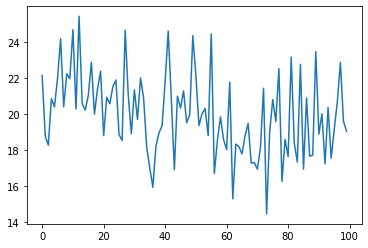

In [2]:
args = run.get_args_parser().parse_args([])
args.experiment_name = "bla"
args.seed = 0
args.full_training_data = True
args.num_particles = 10
args.insomnia = 0.5
args.algorithm = "cmws_2"
args.continue_training = True
args.memory_size = 5
args.num_sleep_pretraining_iterations = 100
args.sleep_pretraining_batch_size = 50

device = cmws.util.get_device()

# Data
train_dataset = data.TimeseriesDataset(device, False, full_data=args.full_training_data)
obs, obs_id = train_dataset[29:30]
obs_id *= 0

# Model
old_algorithm = args.algorithm
args.algorithm = "bla"
model, optimizer, stats = timeseries_util.init(args, device)
generative_model, guide, memory = (
    model["generative_model"],
    model["guide"],
    model["memory"],
)
memory = cmws.memory.Memory(
    1,
    args.memory_size,
    generative_model
).to(device)
args.algorithm = old_algorithm


# Sleep pretraining
if "sleep_pretraining_batch_size" in args:
    if args.sleep_pretraining_batch_size == 0:
        sleep_pretraining_batch_size = args.num_particles * args.batch_size
    else:
        sleep_pretraining_batch_size = args.sleep_pretraining_batch_size
else:
    sleep_pretraining_batch_size = args.num_particles * args.batch_size
for iteration in range(args.num_sleep_pretraining_iterations):
    # Zero grad
    optimizer.zero_grad()

    # Evaluate loss
    loss = losses.get_sleep_loss(
        generative_model, guide, sleep_pretraining_batch_size
    ).mean()

    # Compute gradient
    loss.backward()

    # Step gradient
    optimizer.step()

    # Record stats
    stats.sleep_pretraining_losses.append(loss.item())

    # Log
    if iteration % args.log_interval == 0:
        cmws.util.logging.info(
            f"Sleep Pretraining Iteration {iteration} | "
            f"Loss = {stats.sleep_pretraining_losses[-1]:.0f} | "
            f"Max GPU memory allocated = {cmws.util.get_max_gpu_memory_allocated_MB(device):.0f} MB"
        )
plt.plot(stats.sleep_pretraining_losses)

# Main training loop

0 | 575984.6875 | -362.3258056640625 | 2563655.0


/om/user/tuananh/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/om/user/tuananh/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:580: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


Cannot parse char: 


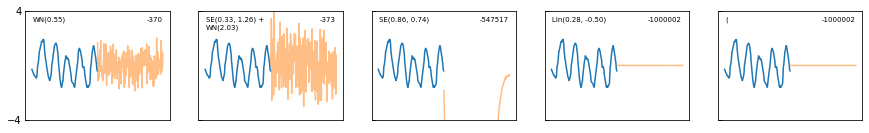

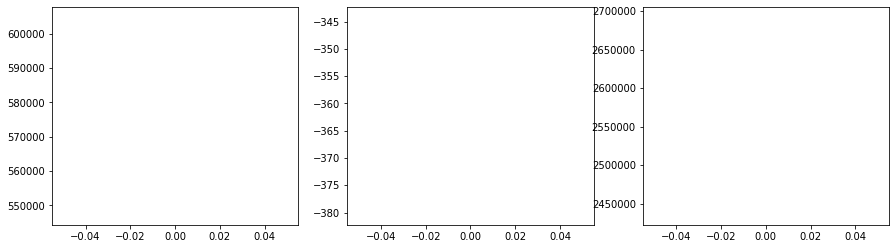

10 | 304.35345458984375 | -191.2129364013672 | 1795306.0


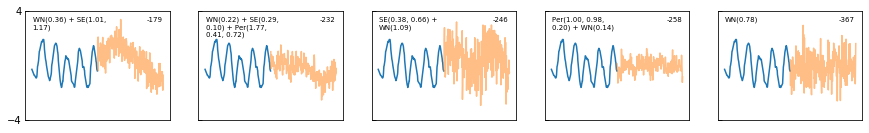

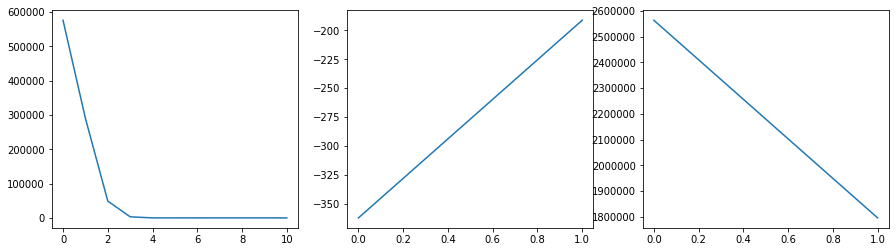

20 | 221.34780883789062 | -79.79576873779297 | 1466690.75


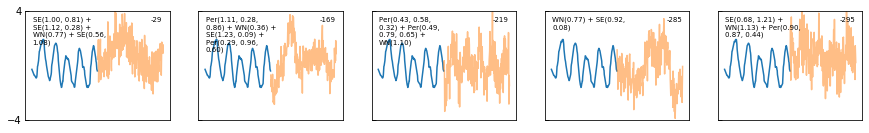

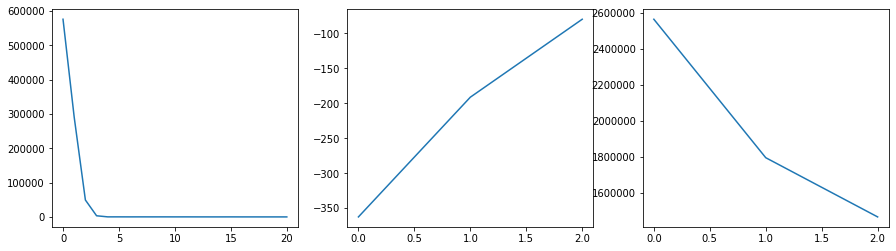

30 | 72.28081512451172 | 182.00929260253906 | 1505284.0


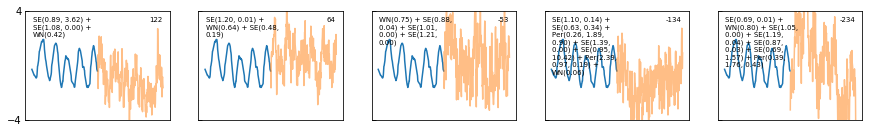

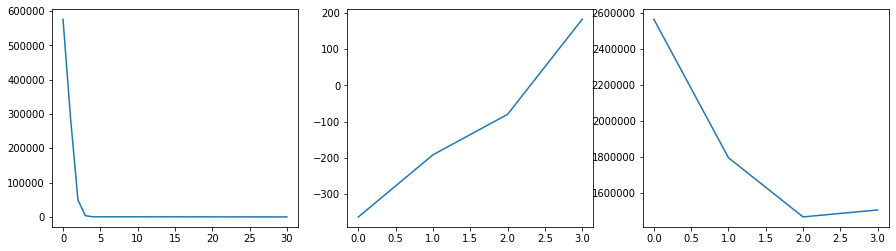

40 | -38.0052490234375 | 167.67918395996094 | 1408599.125


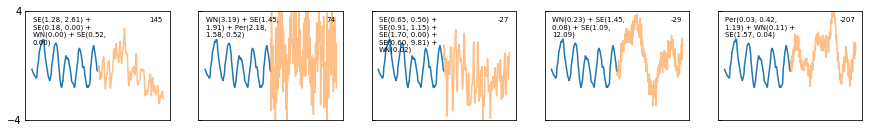

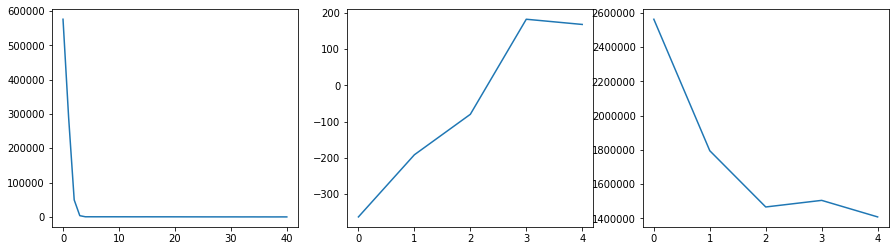

50 | 5.6559906005859375 | 183.0087127685547 | 691272.0


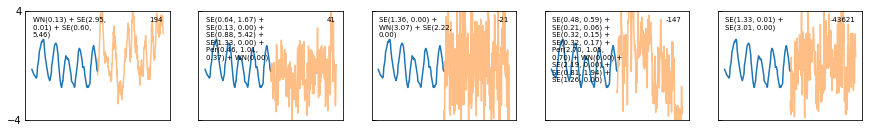

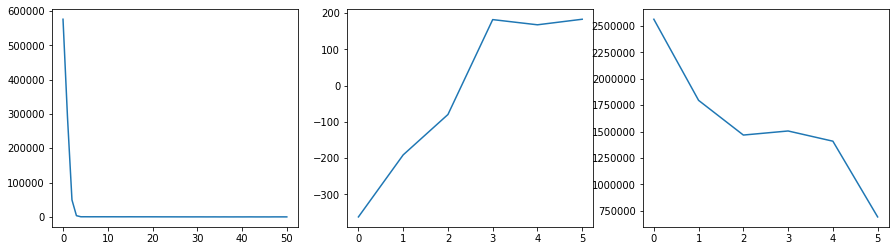

60 | 42.096343994140625 | 159.6815643310547 | 532581.0625


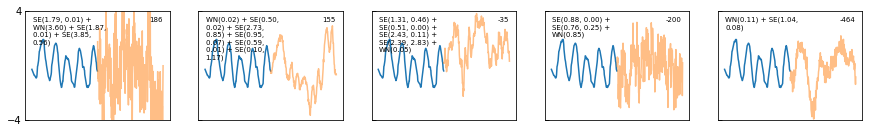

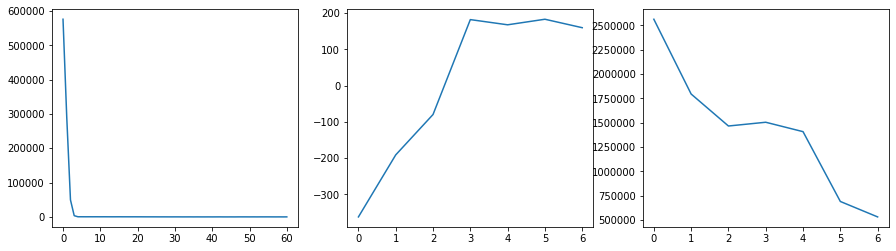

70 | -7.580577850341797 | 172.5177764892578 | 183749.71875


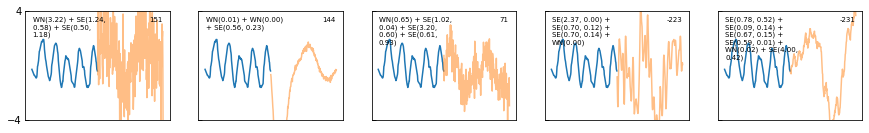

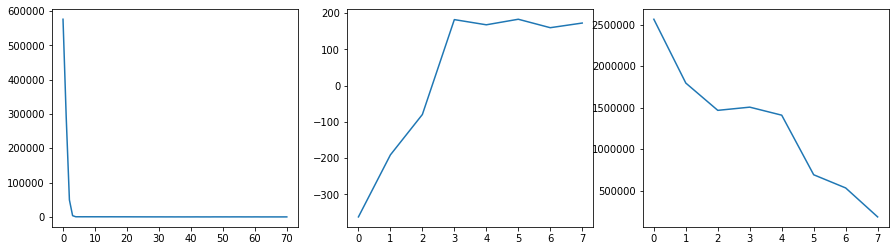

80 | 21.751754760742188 | 195.94400024414062 | 449154.96875


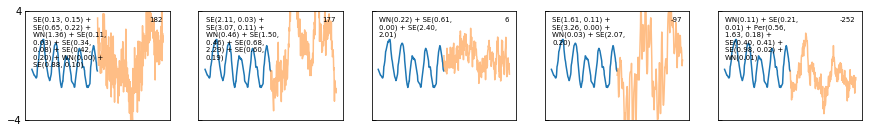

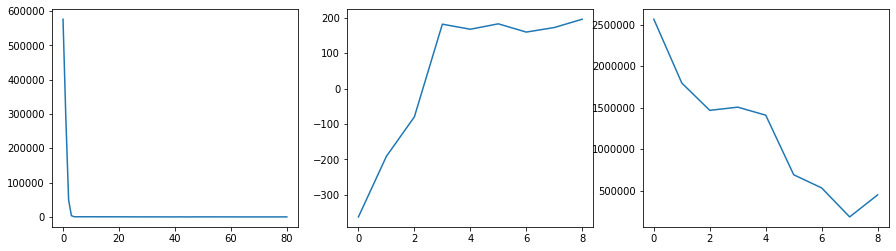

90 | -13.473228454589844 | 200.4158172607422 | 220101.84375


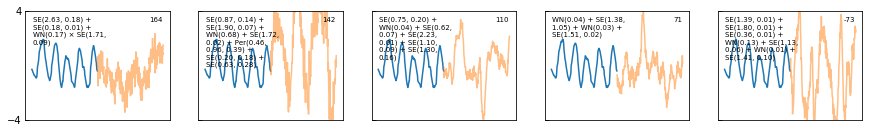

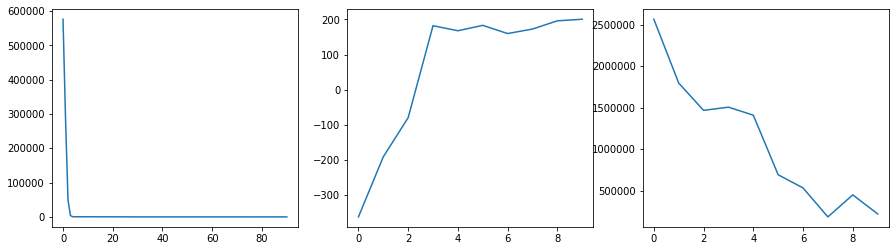

100 | -54.20085144042969 | 196.83055114746094 | 136761.8125


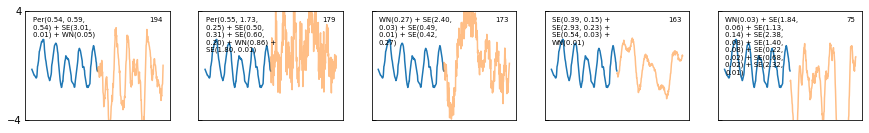

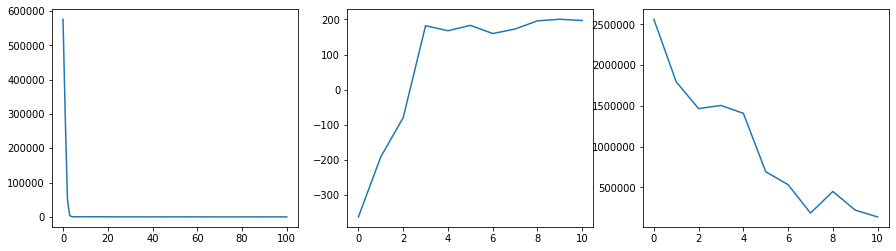

In [ ]:
num_iterations = 100000
losses_, log_p_, kl_ = [], [], []

for i in range(num_iterations):
    # Zero grad
    optimizer.zero_grad()

    if args.algorithm == "cmws":
        loss = losses.get_cmws_loss(
            generative_model,
            guide,
            memory,
            obs,
            obs_id,
            args.num_particles,
            args.num_proposals_mws,
            insomnia=args.insomnia,
        ).mean()
    if args.algorithm == "cmws_2":
        loss = losses.get_cmws_2_loss(
            generative_model,
            guide,
            memory,
            obs,
            obs_id,
            args.num_particles,
            args.num_proposals_mws,
            insomnia=args.insomnia,
        ).mean()
    elif args.algorithm == "rws":
        loss = losses.get_rws_loss(
            generative_model,
            guide,
            obs,
            args.num_particles,
            insomnia=args.insomnia,
        )

    # Compute gradient
    loss.backward()

    # Step gradient
    optimizer.step()
    losses_.append(loss.item())
    
    if i % 10 == 0:
        log_p, kl = losses.get_log_p_and_kl(generative_model, guide, obs, 200)
        log_p_.append(log_p.item())
        kl_.append(kl.item())
        print(f"{i} | {losses_[-1]} | {log_p_[-1]} | {kl_[-1]}")
        plot_predictions_timeseries(generative_model, guide, obs, memory, obs_id)
        plt.show()
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        axs[0].plot(losses_)
        axs[1].plot(log_p_)
        axs[2].plot(kl_)
        plt.show()


# Trying to further optimize continuous params using gradient descent

In [ ]:
raw_expression, eos, gp_raw_params = guide.sample(obs[0])
get_full_expression(raw_expression, eos, gp_raw_params)

In [ ]:
# gp_raw_params_opt = gp_raw_params.clone().detach().requires_grad_(True)
gp_raw_params_opt = torch.randn(gp_raw_params.shape, device=device, requires_grad=True)
opt = torch.optim.Adam([gp_raw_params_opt])


losss = []
num_iterations = 10000
for i in range(num_iterations):
    opt.zero_grad()
    loss = -get_obs_log_prob(raw_expression, eos, gp_raw_params_opt, obs).sum()
    loss.backward()
    opt.step()
    losss.append(loss.item())
    if i % 100 == 0:
        print(f"{i} | {losss[-1]}")
        plt.plot(losss)
        plt.show()
        print(get_full_expression(raw_expression, eos, gp_raw_params_opt))

In [ ]:
obs_predictions = generative_model.sample_obs_predictions((raw_expression, eos, gp_raw_params_opt), obs[0])